## YouTube Trending Video Analysis & Prediction

### Joel Day, Caleb McCurdy, & Lane Whitmore

### The University of San Diego

#### ADS 508 - Data Science Cloud Computing

In [2]:
!pip --disable-pip-version-check -q  install transformers
!pip --disable-pip-version-check -q install pyathena
!pip --disable-pip-version-check -q install torch==1.7.0

In [3]:
# General imports
import pandas as pd
import numpy as np
import collections

# nlp processing imports
import string
import re
import nltk
from transformers import DistilBertTokenizer


# sklearn packages
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# Sagemaker imports
import sagemaker
from sagemaker import get_execution_role


# athena connection imports
from pyathena import connect
import boto3

import torch
from sagemaker.pytorch import PyTorch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

## Establishing Athena for SQL Queries

In [4]:
region = boto3.Session().region_name
role = get_execution_role()

In [5]:
# Set Athena for data wrangling // exploration
session = sagemaker.Session()

# this sets the bucket to the default sagemaker bucket
bucket = session.default_bucket()
print(bucket)

sagemaker-us-east-1-492991381452


In [6]:
ingest_create_athena_db_passed = False

db_name = "youtubedb"

In [7]:
# temp query storage
s3_athena = "s3://{}/athena/tmp/".format(bucket)

# file storage
youtube_dir = "s3://{}/athena/files/".format(bucket)

# creating connection to database
conn = connect(region_name=region, s3_staging_dir=s3_athena)

### Creating Database

In [8]:
# Creating DATABASE with db_name above
create_db = "CREATE DATABASE IF NOT EXISTS {}".format(db_name)

pd.read_sql(create_db, conn)

""


### Creating Tables

#### CSV Tables

Currently, the tables below are still struggling to appropriately populate the tables. If the data type is anything but strings, the column becomes null for all values and the comma seperation is not consistent.

In [9]:
pd.read_sql(f"DROP TABLE IF EXISTS {db_name}.ca_csv", conn)


ca_csv_create = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {db_name}.ca_csv(
                video_id string,
                title string,
                publishedAt string,
                channelId string,
                channelTitle string,
                categoryId string,
                trending string,
                tags string,
                view_count string,
                likes string,
                dislikes string,
                comment_count string,
                thumbnail_link string,
                comments_disabled string,
                ratings_disabled string,
                description string)
            
                
                ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde' 
                WITH SERDEPROPERTIES (
                "separatorChar" = ",", 
                "quoteChar" = '\"',
                "escapeChar" = '\"'
                ) 
                LOCATION 's3://{bucket}/youtubeStatistics/csv/can/'
                TBLPROPERTIES ("skip.header.line.count"="1");
"""

pd.read_sql(ca_csv_create, conn)

""


In [10]:
pd.read_sql(f"SELECT * FROM {db_name}.ca_csv LIMIT 10", conn)

,video_id,title,publishedat,channelid,channeltitle,categoryid,trending,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,Lt9qS5CrfxA,Dan's First ANIMATRONIC Furry Experience - Fiv...,2021-10-27T17:00:19Z,UC9CuvdOVfMPvKCiwdGKL3cQ,GameGrumps,20,2021-10-28T00:00:00Z,lets play|walkthrough|gameplay|egoraptor|danny...,278846,20688,175,2651,https://i.ytimg.com/vi/Lt9qS5CrfxA/default.jpg,False,False,The sparking cables and GRINDING gears make it...
1,JWf3RdkL8XA,Gave both of my Customers some Ski goggles 😂 #...,2021-10-10T19:29:38Z,UCFOjsHNR62Bd8z63xv-wMmA,Kabonster,28,2021-10-28T00:00:00Z,[None],15126828,1028137,23515,2176,https://i.ytimg.com/vi/JWf3RdkL8XA/default.jpg,False,False,
2,SBQlKwZnIFA,The New Range Rover - the Definition of Luxury...,2021-10-26T20:04:40Z,UCZANLEnWKjMbuIkCtDUOqlA,Land Rover,2,2021-10-28T00:00:00Z,[None],417813,13766,257,1070,https://i.ytimg.com/vi/SBQlKwZnIFA/default.jpg,False,False,The New Range Rover is the definition of luxur...
3,XCbMVbeKlCg,Halo Infinite - Campaign Overview,2021-10-25T13:00:13Z,UCjBp_7RuDBUYbd1LegWEJ8g,Xbox,20,2021-10-28T00:00:00Z,Xbox|Xbox One|Xbox Series X|Xbox Series S|Halo...,1815943,133715,3623,8797,https://i.ytimg.com/vi/XCbMVbeKlCg/default.jpg,False,False,The Banished have defeated UNSC forces and tak...
4,vs16SToKSZI,"Best Crayon Art Wins $5,000 Challenge! | ZHC C...",2021-10-25T16:47:58Z,UCPAk4rqVIwg1NCXh61VJxbg,ZHC Crafts,26,2021-10-28T00:00:00Z,[None],2189675,81532,1456,7059,https://i.ytimg.com/vi/vs16SToKSZI/default.jpg,False,False,I can't believe we made art out of crayons lol...
5,CbBCgRUppUU,Drew and Ex-Husband Tom Green Reflect on Their...,2021-10-26T14:04:27Z,UCWIj8e2_-uK1m886ADSYO6g,The Drew Barrymore Show,24,2021-10-28T00:00:00Z,drew barrymore|drew barrymore show|drew barrym...,196851,2306,44,350,https://i.ytimg.com/vi/CbBCgRUppUU/default.jpg,False,False,Though Drew and Tom Green had an intense sit d...
6,HK_-UHXPl2U,Ocarina of Time on Switch Differences,2021-10-27T01:30:41Z,UCk9RA3G-aVQXvp7-Q4Ac9kQ,ZFG,20,2021-10-28T00:00:00Z,The Legend of Zelda|Ocarina of Time|Speedrun|G...,153732,5179,142,1082,https://i.ytimg.com/vi/HK_-UHXPl2U/default.jpg,False,False,Here's a large list of the differences I and t...
7,N-7j2ejytyI,Apex Legends: Escape Gameplay Trailer,2021-10-25T15:00:14Z,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,20,2021-10-28T00:00:00Z,apex legends|apex|apex legends season 11|apex ...,3227958,171742,1404,9143,https://i.ytimg.com/vi/N-7j2ejytyI/default.jpg,False,False,The beauty of the new Storm Point map is beyon...
8,r2e-Bcw93Cs,This is my most chaotic GTA 5 Races video yet,2021-10-26T22:00:32Z,UCzXwjTI6c6mVn6oui_p6oiw,SMii7Y,20,2021-10-28T00:00:00Z,grand theft auto|grand theft auto v|grand thef...,1012339,78114,356,1822,https://i.ytimg.com/vi/r2e-Bcw93Cs/default.jpg,False,False,I'm not jokingLeave a like and Subscribe if yo...
9,sroXzp6ueC8,i can quit whenever honestly,2021-10-27T16:51:10Z,UC-lHJZR3Gqxm24_Vd_AJ5Yw,PewDiePie,24,2021-10-28T00:00:00Z,pewdiepie|pewds|pewdie,2145724,262196,1411,16040,https://i.ytimg.com/vi/sroXzp6ueC8/default.jpg,False,False,🧎#Subscribe🧎🥤Gfuel(affiliate): https://gfuel.l...


In [11]:
pd.read_sql(f"DROP TABLE IF EXISTS {db_name}.us_csv", conn)


us_csv_create = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {db_name}.us_csv(
                video_id string,
                title string,
                publishedAt string,
                channelId string,
                channelTitle string,
                categoryId string,
                trending string,
                tags string,
                view_count string,
                likes string,
                dislikes string,
                comment_count string,
                thumbnail_link string,
                comments_disabled string,
                ratings_disabled string,
                description string)
            
                
                ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde' 
                WITH SERDEPROPERTIES (
                "separatorChar" = ',', 
                "quoteChar" = '\"',
                "escapeChar" = '\"'
                ) 
                LOCATION 's3://{bucket}/youtubeStatistics/csv/usa/'
                TBLPROPERTIES ("skip.header.line.count"="1");
"""

pd.read_sql(us_csv_create, conn)

""


In [12]:
pd.read_sql(f"SELECT * FROM {db_name}.us_csv LIMIT 10", conn)

,video_id,title,publishedat,channelid,channeltitle,categoryid,trending,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,wLeVZztNWDo,Justin Bieber - Peaches (Live with WeTheBand),2021-03-19T04:02:46Z,UCIwFjwMjI0y7PDBVEO9-bkQ,Justin Bieber,10,2021-03-19T00:00:00Z,justin|bieber|justinbieber|purpose|myworld|jou...,489879,61317,435,1074,https://i.ytimg.com/vi/wLeVZztNWDo/default.jpg,False,False,Justice the album out now: https://justinbiebe...
1,Su6kidaGW_8,Justin Bieber: Tiny Desk (Home) Concert,2021-03-17T16:00:15Z,UC4eYXhJI4-7wSWc8UNRwD4A,NPR Music,10,2021-03-19T00:00:00Z,NPR|NPR Music|National Public Radio|Live|Perfo...,2104382,107557,3231,8155,https://i.ytimg.com/vi/Su6kidaGW_8/default.jpg,False,False,More from NPR Music: Tiny Desk Concerts: https...
2,QDoF8jwMcH0,Making a Bond Car Top Gear Collab Part 1,2021-03-18T16:00:21Z,UCp68_FLety0O-n9QU6phsgw,colinfurze,24,2021-03-19T00:00:00Z,Colin|furze|top gear|James Bond,556717,43940,486,2530,https://i.ytimg.com/vi/QDoF8jwMcH0/default.jpg,False,False,My name's Furze... Colin Furze haha. Project 0...
3,18-VtLh-6OA,Genius Prank! He Was Soaking 😂💦,2021-03-15T12:07:51Z,UCDgNRuWdouD-dXgrM3fF41Q,Woody & Kleiny Extra,22,2021-03-19T00:00:00Z,shorts|viral|comedy|best friends|best of woody...,5094894,189361,6075,508,https://i.ytimg.com/vi/18-VtLh-6OA/default.jpg,False,False,HILARIOUS HOT CHOCOLATE PRANKThis is why you s...
4,bHEo4jQp7iw,Doja Cat - Say So (LIVE at the 63rd GRAMMYs),2021-03-16T23:13:34Z,UCpTaAz_BxtkUB1qc8JTU_7g,dojacatVEVO,10,2021-03-19T00:00:00Z,doja cat|streets|grammys|doja cat grammys|doja...,4746448,240966,6236,11517,https://i.ytimg.com/vi/bHEo4jQp7iw/default.jpg,False,False,Doja Cat // “Say So” (LIVE at the 63rd GRAMMYs...
5,NDqu6aKRfVc,"Sharon Osbourne Responds To Julie Chen, Sara G...",2021-03-17T19:11:45Z,UCKY5PiEq8Tl9r7f3qittXng,ET Canada,24,2021-03-19T00:00:00Z,entertainment|news|et canada|entertainment ton...,744872,6717,1637,5173,https://i.ytimg.com/vi/NDqu6aKRfVc/default.jpg,False,False,None
6,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
7,https://www.youtube.com/user/ETCanadaOfficial,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
8,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
9,FOLLOW us here:,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [13]:
pd.read_sql(f"DROP TABLE IF EXISTS {db_name}.gb_csv", conn)


gb_csv_create = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {db_name}.gb_csv(
                video_id string,
                title string,
                publishedAt string,
                channelId string,
                channelTitle string,
                categoryId string,
                trending string,
                tags string,
                view_count string,
                likes string,
                dislikes string,
                comment_count string,
                thumbnail_link string,
                comments_disabled string,
                ratings_disabled string,
                description string
                )
            
                ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde' 
                WITH SERDEPROPERTIES (
                "separatorChar" = ",", 
                "quoteChar" = '\"',
                "escapeChar" = '\"'
                ) 
                LOCATION 's3://{bucket}/youtubeStatistics/csv/gb/'
                TBLPROPERTIES ("skip.header.line.count"="1");
"""

pd.read_sql(gb_csv_create, conn)

""


In [14]:
pd.read_sql(f"SELECT * FROM {db_name}.gb_csv LIMIT 10", conn)

,video_id,title,publishedat,channelid,channeltitle,categoryid,trending,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,► Check out our Community tab for more stories...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,► Listen to our podcasts: https://www.ft.com/...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,NT9UKghTGLs,We did ILLEGAL Things While Driving,2022-10-19T17:24:12Z,UCNBbCOuAN1NZAuj0vPe_MkA,Car Throttle,2,2022-10-24T00:00:00Z,drink|driving|illegal|phone|texting|ringing|ca...,295429,10142,0,545,https://i.ytimg.com/vi/NT9UKghTGLs/default.jpg,False,False,This week Alex and Jack experiment with things...
5,xT3059r4-Qo,Sculptures Of Anything Goes,2022-10-20T10:49:10Z,UC8Yu1_yfN5qPh601Y4btsYw,Arctic Monkeys - Topic,10,2022-10-24T00:00:00Z,Arctic Monkeys|The Car|Sculptures Of Anything ...,214250,11378,0,0,https://i.ytimg.com/vi/xT3059r4-Qo/default.jpg,False,False,Provided to YouTube by DominoSculptures Of Any...
6,FcoVzLyFqNs,Norway's strongest man VS Rock Climbing,2022-10-19T16:01:16Z,UC_gSotrFVZ_PiAxo3fTQVuQ,Magnus Midtbø,17,2022-10-24T00:00:00Z,Climbing|Sondre Berg|Climb|calisthenics|Boulde...,2297349,42398,0,2000,https://i.ytimg.com/vi/FcoVzLyFqNs/default.jpg,False,False,Get Exclusive NordVPN deal here ➼ https://no...
7,NT14sw0_RRc,Prime Minister's Questions (PMQs) - 19 October...,2022-10-19T12:45:19Z,UCMasyWuE1P2AaEKw_FkGq9g,UK Parliament,25,2022-10-24T00:00:00Z,#PMQs,100610,889,0,0,https://i.ytimg.com/vi/NT14sw0_RRc/default.jpg,True,False,The British Sign Language (BSL) version is ava...
8,YBNcYxHJPLE,How the World’s Wealthiest People Travel,2022-10-19T16:01:35Z,UC9RM-iSvTu1uPJb8X5yp3EQ,Wendover Productions,27,2022-10-24T00:00:00Z,[None],1068842,33219,0,3083,https://i.ytimg.com/vi/YBNcYxHJPLE/default.jpg,False,False,Sign up for a CuriosityStream subscription and...
9,QPBz7p9Jh7M,Exploding 250 Pound Glitter Pumpkin!,2022-10-19T18:00:09Z,UC3v6sjWuPxtW36jQ-if4OuA,Imbrandonfarris,23,2022-10-24T00:00:00Z,[None],573190,30981,0,1189,https://i.ytimg.com/vi/QPBz7p9Jh7M/default.jpg,False,False,Kinda..


#### JSON Tables

In [15]:
pd.read_sql(f"DROP TABLE IF EXISTS {db_name}.us_json", conn)

us_json_create = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {db_name}.us_json (
                        kind string, 
                        etag string, 
                        items ARRAY< struct< kind: string, 
                                             etag: string,
                                             id: string,
                                             snippet: ARRAY< struct<
                                                            title: string,
                                                            assignable: string,
                                                            channelId: string
                                                    >>
                                        >>
                        )
                        ROW FORMAT SERDE 'org.openx.data.jsonserde.JsonSerDe'
                        WITH SERDEPROPERTIES ( 
                                                "ignore.malformed.json"="true"
                                             )
                        LOCATION 's3://{bucket}/youtubeStatistics/json/usa/US_category_id_test.json';
"""

pd.read_sql(us_json_create, conn)

""


In [16]:
query_json_us = f"""SELECT 
                    its.kind, 
                    its.etag, 
                    its.id, 
                    snt.title, 
                    snt.assignable, 
                    snt.channelId 
                    FROM {db_name}.us_json, 
                    UNNEST({db_name}.us_json.items) AS t(its),
                    UNNEST(its.snippet) AS t(snt)
                    WHERE snt.title = 'gaming';
"""

pd.read_sql(query_json_us, conn)

,kind,etag,id,title,assignable,channelId


In [17]:
statement = "SHOW DATABASES"
db_show = pd.read_sql(statement, conn)
db_show.head(5)

,database_name
0,default
1,youtubedb
2,youtubestatistics


In [18]:
if db_name in db_show.values:
    ingest_create_athena_db_passed = True

In [19]:
%store ingest_create_athena_db_passed

Stored 'ingest_create_athena_db_passed' (bool)


## Exploratory Data Analysis

#### US American Gaming Exploration

Preparing the data for exploration by adjusting the necessary column types.

### Initial Preprocesssing and transformations to visualize the data properly

#### Data Import 

The data set below is created from the United States area where categoryid = 20 or 'Gaming' category on Youtube. As many of the creators under our companies umbrella do create 'Gaming' content, it is a key area for ViewBoost to focus in on. It also provides an opportunity to refine a robust deep learning neural network as there is still 37,000 records within the US Gaming segment. 

In [20]:
# 20 is the category id for gaming in each country
us_gaming = pd.read_sql(f"SELECT * FROM {db_name}.us_csv WHERE us_csv.categoryid LIKE '20';", conn)
us_gaming.head()

,video_id,title,publishedat,channelid,channeltitle,categoryid,trending,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,rpd2-a4lr5c,stop getting these tattoos,2022-06-22T22:46:58Z,UCZ3AmknSJtbzXCeO5a4peoQ,LazarLazar,20,2022-06-24T00:00:00Z,[None],1733881,88292,0,2311,https://i.ytimg.com/vi/rpd2-a4lr5c/default.jpg,False,False,i love my communityREDDIT - https://www.reddit...
1,n3_rnYClz9U,Minecraft but Everything I Touch turns to Cartoon,2022-06-23T14:24:22Z,UCKGNVB2moP-zeAWPmw8HvAA,Craftee,20,2022-06-24T00:00:00Z,minecraft|minecraft but|new minecraft|craftee|...,1779596,46722,0,2116,https://i.ytimg.com/vi/n3_rnYClz9U/default.jpg,False,False,Playing Minecraft while Everything I Touch tur...
2,_nW9RCoWxcQ,WHAT ARE THEY DOING?! - OFFLINETV UNBOXING,2022-06-22T22:00:24Z,UCDK9qD5DAQML-pzrtA7A4oA,OfflineTV,20,2022-06-24T00:00:00Z,OfflineTV|Scarra|Poki|Pokimane|Lily|LilyPichu|...,1462193,98118,0,2665,https://i.ytimg.com/vi/_nW9RCoWxcQ/default.jpg,False,False,Thank you for the lovely gifts & we’ll see you...
3,QDeJ06iRbWA,3D Gaming - Scott The Woz,2022-06-23T00:00:07Z,UC4rqhyiTs7XyuODcECvuiiQ,Scott The Woz,20,2022-06-24T00:00:00Z,[None],696766,54888,0,3137,https://i.ytimg.com/vi/QDeJ06iRbWA/default.jpg,False,False,None
4,vyNi64Np1Q8,"Minecraft But Anything You Build, You Get...",2022-06-23T02:00:10Z,UCETZ7OiW7-wqwb-6hsz3C4w,Bionic,20,2022-06-24T00:00:00Z,minecraft|Minecraft But Anything You Build You...,1555311,55822,0,2997,https://i.ytimg.com/vi/vyNi64Np1Q8/default.jpg,False,False,"Minecraft But Anything You Build, You Get...🎥 ..."


##### Data type transformations

In [21]:
print("Length of data frame:", us_gaming.shape[0])
print("Width of data frame:", us_gaming.shape[1])
print("Initial data types:", us_gaming.dtypes)


# Change to integer
us_gaming['categoryid'] = us_gaming['categoryid'].astype(int) 
us_gaming['view_count'] = us_gaming['view_count'].astype(int)
us_gaming['likes'] = us_gaming['likes'].astype(int)
us_gaming['dislikes'] = us_gaming['dislikes'].astype(int)
us_gaming['comment_count'] = us_gaming['comment_count'].astype(int)


# Change to bool then int representations
us_gaming['ratings_disabled'] = us_gaming['ratings_disabled'].astype(bool).apply(int)
us_gaming['comments_disabled'] = us_gaming['comments_disabled'].astype(bool).apply(int)



# Change to datetime
us_gaming['publishedat'] = pd.to_datetime(us_gaming['publishedat'], infer_datetime_format=True)
us_gaming['trending'] = pd.to_datetime(us_gaming['trending'], infer_datetime_format=True)



print(us_gaming.isnull().sum())
print("New data types:", us_gaming.dtypes)
us_gaming.head()

Length of data frame: 37071
Width of data frame: 16
Initial data types: video_id             object
title                object
publishedat          object
channelid            object
channeltitle         object
categoryid           object
trending             object
tags                 object
view_count           object
likes                object
dislikes             object
comment_count        object
thumbnail_link       object
comments_disabled    object
ratings_disabled     object
description          object
dtype: object
video_id                0
title                   0
publishedat             0
channelid               0
channeltitle            0
categoryid              0
trending                0
tags                    0
view_count              0
likes                   0
dislikes                0
comment_count           0
thumbnail_link          0
comments_disabled       0
ratings_disabled        0
description          1296
dtype: int64
New data types: video_id             

,video_id,title,publishedat,channelid,channeltitle,categoryid,trending,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,rpd2-a4lr5c,stop getting these tattoos,2022-06-22 22:46:58,UCZ3AmknSJtbzXCeO5a4peoQ,LazarLazar,20,2022-06-24,[None],1733881,88292,0,2311,https://i.ytimg.com/vi/rpd2-a4lr5c/default.jpg,1,1,i love my communityREDDIT - https://www.reddit...
1,n3_rnYClz9U,Minecraft but Everything I Touch turns to Cartoon,2022-06-23 14:24:22,UCKGNVB2moP-zeAWPmw8HvAA,Craftee,20,2022-06-24,minecraft|minecraft but|new minecraft|craftee|...,1779596,46722,0,2116,https://i.ytimg.com/vi/n3_rnYClz9U/default.jpg,1,1,Playing Minecraft while Everything I Touch tur...
2,_nW9RCoWxcQ,WHAT ARE THEY DOING?! - OFFLINETV UNBOXING,2022-06-22 22:00:24,UCDK9qD5DAQML-pzrtA7A4oA,OfflineTV,20,2022-06-24,OfflineTV|Scarra|Poki|Pokimane|Lily|LilyPichu|...,1462193,98118,0,2665,https://i.ytimg.com/vi/_nW9RCoWxcQ/default.jpg,1,1,Thank you for the lovely gifts & we’ll see you...
3,QDeJ06iRbWA,3D Gaming - Scott The Woz,2022-06-23 00:00:07,UC4rqhyiTs7XyuODcECvuiiQ,Scott The Woz,20,2022-06-24,[None],696766,54888,0,3137,https://i.ytimg.com/vi/QDeJ06iRbWA/default.jpg,1,1,None
4,vyNi64Np1Q8,"Minecraft But Anything You Build, You Get...",2022-06-23 02:00:10,UCETZ7OiW7-wqwb-6hsz3C4w,Bionic,20,2022-06-24,minecraft|Minecraft But Anything You Build You...,1555311,55822,0,2997,https://i.ytimg.com/vi/vyNi64Np1Q8/default.jpg,1,1,"Minecraft But Anything You Build, You Get...🎥 ..."


Above lists the new data types in addition to listing the null values. For our dataset the only null values exist in the description column as many of the videos simply have not had a description written, these values are still important for the dataset and should not be dropped. Instead, the null descriptions will be filled with "Not Available" as a way to give the nulls a stand-in value.

#### Handling Duplicate Videos

One major issue with this dataset for the purposes of predicting views for high performing content creators, is that the videos may trend on youtube more than once. In these cases, the scraper used re scraps the video. These duplicates will have to be dropped.  

In [22]:
us_gaming.drop_duplicates('video_id', keep = 'last', inplace = True)

In [23]:
us_gaming.head()

,video_id,title,publishedat,channelid,channeltitle,categoryid,trending,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
189,j0Q3np6UHlA,King Simulator in Among Us,2022-06-23 16:00:21,UCke6I9N4KfC968-yRcd5YRg,SSundee,20,2022-06-27,[None],2249268,112384,0,3639,https://i.ytimg.com/vi/j0Q3np6UHlA/default.jpg,1,1,We add a New Castle Simulator Mod in Among Us ...
193,eNGliThe1uI,FREE BUNDLE for EVERYONE!,2022-06-22 22:49:04,UCbkMvtBNkpIbHqQdKHJSb5A,GhostNinja,20,2022-06-27,Fortnite|Fortnite Chapter 3|Fortnite Update|Fo...,291076,11942,0,763,https://i.ytimg.com/vi/eNGliThe1uI/default.jpg,1,1,Fortnite Naruto Skin Bundle in Item Shop Live ...
196,-XsOZFecEH4,"Minecraft, But Crafts Are GIANT!",2022-06-23 16:15:00,UC0h07r_UgTD0Tc-Dn5XLX3g,Wisp,20,2022-06-27,minecraft|mine craft|dream minecraft|funny|min...,841497,39685,0,1384,https://i.ytimg.com/vi/-XsOZFecEH4/default.jpg,1,1,"Minecraft, But Crafts Are GIANT... (Challenge)..."
197,XCfsvgup-I4,I Cheated with a SECRET ROOM vs BadBoyHalo...,2022-06-22 20:40:58,UCzMjRlKVO9XIqH_crIFpi6w,Skeppy,20,2022-06-27,minecraft|mine craft|minecraft youtuber|skeppy...,440451,27861,0,1226,https://i.ytimg.com/vi/XCfsvgup-I4/default.jpg,1,1,NiceHUGE Thanks to the map makers!!@ArtToAnima...
242,JYHNYiu0yYg,1½ NEW Brawlers + HUGE Improvements to Clubs!,2022-06-25 15:09:20,UCmG2EhfOwSjpPMX4LjGY__A,KairosTime Gaming,20,2022-06-28,Brawl Stars|BrawlStars|Kairos|KairosTime|Kairo...,219110,15080,0,3271,https://i.ytimg.com/vi/JYHNYiu0yYg/default.jpg,1,1,New Brawler Otis Breakdown! Brawl Talk Update!...


##### Null Handling

Null values are important within this dataset and will therefore have words assigned to them for representation. 

In [24]:
us_gaming['description'].fillna("not available", inplace = True)
us_gaming.isna().sum()

video_id             0
title                0
publishedat          0
channelid            0
channeltitle         0
categoryid           0
trending             0
tags                 0
view_count           0
likes                0
dislikes             0
comment_count        0
thumbnail_link       0
comments_disabled    0
ratings_disabled     0
description          0
dtype: int64

The value counts of the binary features below show that both have zero distribution and should not be used in modeling moving forward. 

In [25]:
print(us_gaming['ratings_disabled'].value_counts())
print(us_gaming['comments_disabled'].value_counts())

1    6830
Name: ratings_disabled, dtype: int64
1    6830
Name: comments_disabled, dtype: int64


In [26]:
us_gaming.drop(columns = ['ratings_disabled', 'comments_disabled', 'thumbnail_link'], inplace = True)

us_gaming.shape

(6830, 13)

Now the objects need to be prepared for visualization & modeling. A count vectorizer will be used to create visualizations based up the vocabulary available within the dataset. 

In [27]:
stopwords = nltk.corpus.stopwords.words(['english'])
ps = nltk.PorterStemmer()
extra_stops = ['00','000','007','01','02','03','04','06','07','09sharkboy','10','100','1000','10000','100000','1000000',
               '000001','001','002','004','008','011','013','031','036','037','05','050','062','08','09','094',
               '1001','1006','101','102','103','1050','10m','10t','10th','10x','11','119','12','120','12240','13','132',
               '133','13th','14','1400','140ms','15','150','150k','15th','16','1600','17', '175','18','1800','183','184',
               '188','189','18c','19','19500','20','200','21','2100','2163','21w05a','21w05b','21w06a','21w07a','21w07b',
               '21w08a','21w08b','21w09a','21w13a','21w13b','21w14a','21w14b','22','22w11a','22w13oneblockatatime','22w42a',
               '22w42b','23','23w04a','23w04b','24','25','25000','2500hp','25th','26','27','28','29','2900','296','2b','2b2t',
               '2bt2','2e','31','3100','31415','32','3200','33','34','35','35th','36','360','3600','365','37','3700','39','3900',
               '30th','40','400','4000','40000','4200','43','44','4400','46','4900','4logj','4logshell','4th','4x21','4x28','50',
               '500','5000','50000','505','510mph','52nd','5300','55','56','59','5e','5g','5n','5th','5up','60','600','30','300',
               '3000','303','63','6323','64','64dd','68','69','6a6y','6acc','6locc','6lue','70','700','7000','343i','34547','73',
               '7348951','74','77','781','7900','7th','80','8000','80s','82','84','85','87','876','876tv','898','8bitryan','900',
               '90s','93','94','96','97','99','999','9th','a380','a6d','a750','abc','adc','2006','2007','2007scape','2008','201',
               '2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','202','2020','2021','2022','2023','2030','2042',
               '2045','2050','2077','20th','107','109','1236','1250','128','147','14th','152','157','163','167','179','18th','1909',
               '19931','19th','1ft','1k','1st','1½','2000','2032','217','219','21st','221129','221130','23rd','240','248','250','25688',
               '25k','26th','27th','41','42','425','438','45','4500hp','47','474','48','489','49','136','143','16th','2nd','2wei','3070',
               '3080','3090','30k','348','3500','355','38','4070','4080','4090','40k','4e','51','52','53','54','542','560','562','567',
               '568','570','571','572','575','576','577','58','585','594','6000','61','623','65','66','673','694','6th','40th','7096',
               '71','72','746','75','750','76m','79','7m','800','800x600','817','851','8th','90','91','925','951','97m','996','aang','aau',
               'acnient','anymore','almost','bel','티원롤','파피플레이타임','펌킨','프나펌','프레디','프레디의','피규어','피자가게','허기워기',
               '오징어','제이홉','채색','커스텀','케플러','키즈','탱크맨','티빙에서스트리밍','티원','프라이데이']

for i in extra_stops:
    stopwords.append(i)

vectag = CountVectorizer(stop_words = stopwords)
vecti = CountVectorizer(stop_words = stopwords)
vecdes = CountVectorizer(stop_words = stopwords)

In [28]:
tag = us_gaming['tags']
title = us_gaming['title']
description = us_gaming['description']

tags = vectag.fit_transform(tag)
titles = vecti.fit_transform(title)
#descriptions = vecdes.fit_transform(description)

# printing shape of the vectors
print(tags.shape)
print(titles.shape)
#print(descriptions.shape)

# creating df from new extracted string values
tag_df = pd.DataFrame(tags.todense(), columns = vectag.get_feature_names())
title_df = pd.DataFrame(titles.todense(), columns = vecti.get_feature_names())

(6830, 11494)
(6830, 6043)


### Creating Visualizations

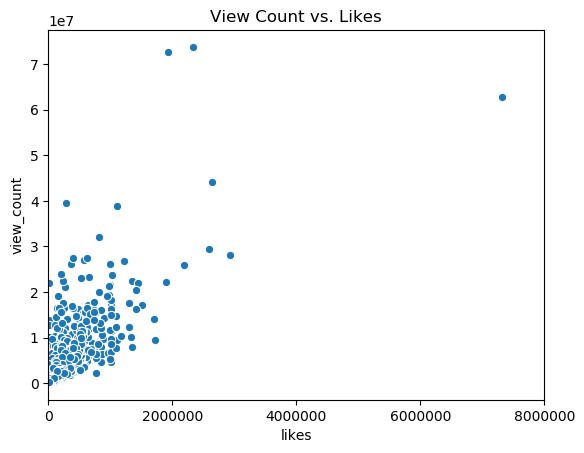

In [29]:
fig, ax = plt.subplots()

sns.scatterplot(data = us_gaming, x = "likes", y = "view_count", ax = ax)
plt.title("View Count vs. Likes")
ax.set_xlim(0, 8000000)
ax.set_xticks([0, 2000000, 4000000, 6000000, 8000000])
plt.show()

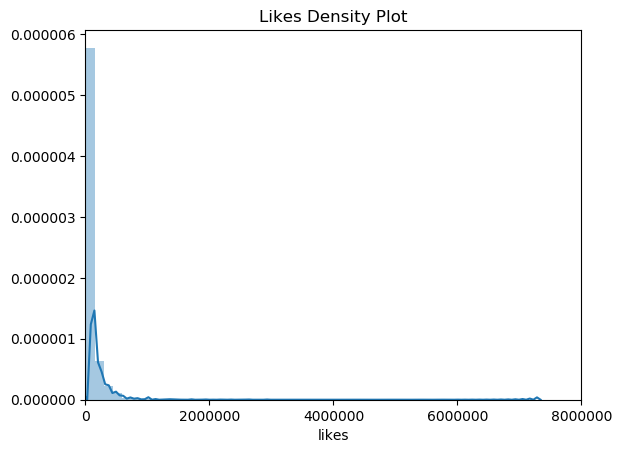

In [30]:
fig, ax = plt.subplots()

sns.distplot(us_gaming.likes, ax = ax)
plt.title("Likes Density Plot")
ax.set_xlim(0, 8000000)
ax.set_xticks([0, 2000000, 4000000, 6000000, 8000000])
plt.show()

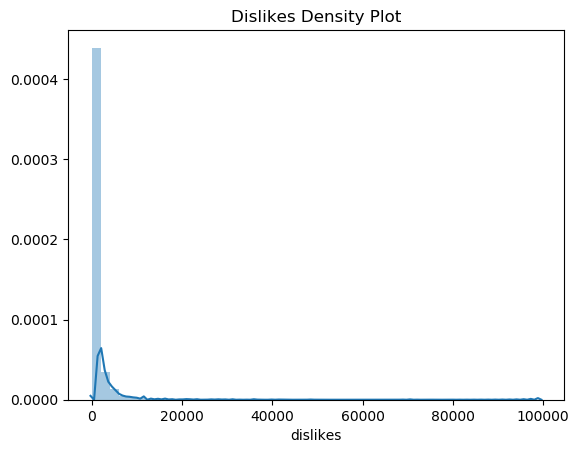

In [31]:
sns.distplot(us_gaming.dislikes)
plt.title("Dislikes Density Plot")
plt.show()

faze is a popular, legacy gaming brand at this point. Below the faze gaming organization 100t is charted as well, 100t is new gaming brand, although already find themselves very successful on YouTube. Looking at the comparison, faze, particularly prior to 2022, is the much stronger brand on YouTube, Perhaps when working out deals or collaborations with gaming brand with our creators, it would be more lucrative to attach our creators to faze's brand rather than 100t. 

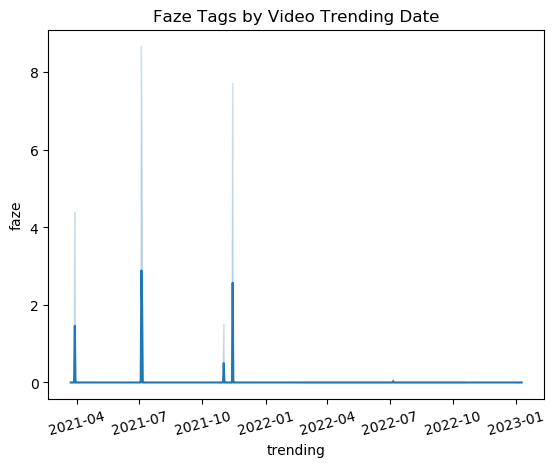

In [32]:
sns.lineplot(x = us_gaming["trending"], y = tag_df["faze"])
plt.xticks(rotation = 15)
plt.title("Faze Tags by Video Trending Date")
plt.show()

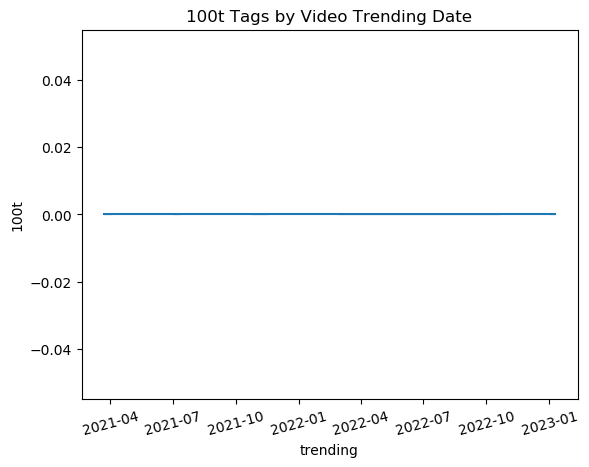

In [33]:
sns.lineplot(x = us_gaming['trending'], y = tag_df['100t'])
plt.xticks(rotation = 15)
plt.title("100t Tags by Video Trending Date")
plt.show()

Below the recently developed game Valorant is compared to Mario, one of the most popular games in existence. Mario games are more likely to trend on any given day as the time series is much more dense, but the peaks of Valorant are slightly higher. Both of these games could viably be a valuable addition to a creator's video title. 

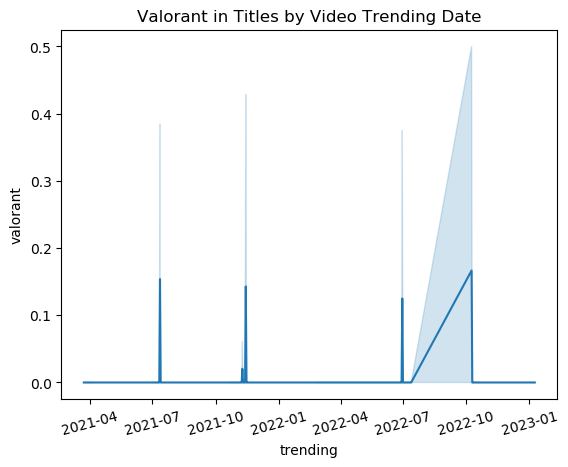

In [34]:
sns.lineplot(x = us_gaming['trending'], y = title_df['valorant'])
plt.xticks(rotation = 15)
plt.title("Valorant in Titles by Video Trending Date")
plt.show()

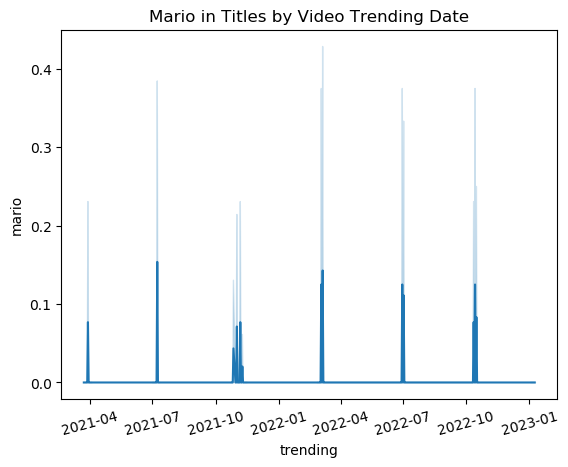

In [35]:
sns.lineplot(x = us_gaming['trending'], y = title_df['mario'])
plt.xticks(rotation = 15)
plt.title("Mario in Titles by Video Trending Date")
plt.show()

### Feature Selection Final Decisions

Ultimately, as the goal of the project is to predict views, dislikes, likes, comment count, posting date, trending date, channelid, channel title, and thumbnail link cannot be used as predictors because we hope to predict the view count of the video before the video is posted. Perhaps in future projects an image recognition model can be used to predict views based upon thumbnail photos, but this project will be limited to text. Going forward, NLP techinques will be used to create a deep learning regression model from any combination of title, tags, and description in order to predict view count on videos as view count leads to greater growth for the creators. Particularly because, as the first scatterplot reveals above, high view count often lead to high likes which in turn leads to being boosted on the trending algorithm. The more eyes on the video, the more likely to trend. 

## Tokenization Transformations to Implement Torch.nn modeling

The distilbert tokenizer below is from the pretrained base case as it would take nearly a million records to properly train a robust tokenizer. Perhaps, in the future a YouTube specific tokenizer should be created once the project has been proved successful to shareholders based on potentially tens of millions or hundreds of millions of YouTube video content. As an exploratory project, we will limit our scope to the base distilbert tokenizer.

The tokenizer will be used to encode the title, tags, and description of each youtube video in order to transform the string to tokens. This is an imporvement over the vectorization above as tokenizing the data will offer more context to the words and allow the model to learn what is around the words rather than just the words themselves. 

In [36]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

encoded_title = tokenizer(text=us_gaming.title.tolist(),
                            add_special_tokens=True,
                            padding='max_length',
                            truncation='longest_first',
                            max_length=300,
                            return_attention_mask=True)
title_input_ids = encoded_title['input_ids']
title_input_mask = encoded_title['attention_mask']


encoded_tags = tokenizer(text=us_gaming.tags.tolist(),
                            add_special_tokens=True,
                            padding='max_length',
                            truncation='longest_first',
                            max_length=300,
                            return_attention_mask=True)
tags_input_ids = encoded_tags['input_ids']
tags_input_mask = encoded_tags['attention_mask']


encoded_desc = tokenizer(text=us_gaming.description.tolist(),
                            add_special_tokens=True,
                            padding='max_length',
                            truncation='longest_first',
                            max_length=300,
                            return_attention_mask=True)
desc_input_ids = encoded_desc['input_ids']
desc_input_mask = encoded_desc['attention_mask']

The train test splits below use a 85/15 split that leaves 5,805 records to train with. It also uses labels and random state to ensure that all the arrays or lists are split along the same indexes across our main three string locations; title, tags, and description. View Count has been seperated as the response variable for the model to predict.

In [37]:
labels = us_gaming.view_count

In [38]:
title_train_id, title_test_id, title_train_mask, title_test_mask, train_labels, test_labels = train_test_split(title_input_ids, title_input_mask, labels, train_size = 0.85, random_state = 50)

tag_train_id, tag_test_id, tag_train_mask, tag_test_mask, _, _ = train_test_split(tags_input_ids, tags_input_mask, labels, train_size = 0.85, random_state = 50)

desc_train_id, desc_test_id, desc_train_mask, desc_test_mask, _, _ = train_test_split(desc_input_ids, desc_input_mask, labels, train_size = 0.85, random_state = 50)


In [39]:
print("Train size: ", len(title_train_id))
print("Test size: ", len(title_test_id))

Train size:  5805
Test size:  1025


This is the final transformation for the strings before modeling. The strings have been encoded/tokenized, placed into pytorch tensors, made into a tensor dataset and ultimately transformed into a dataloader for both train and the test set. 

In [40]:
batch_size = 32

def create_dataloaders(titleids, tagids, descids, titlemasks, tagmasks, descmasks, labels, batch_size):
    title_id_tensor = torch.tensor(titleids)
    tag_id_tensor = torch.tensor(tagids)
    desc_id_tensor = torch.tensor(descids)
    title_mask_tensor = torch.tensor(titlemasks)
    tag_mask_tensor = torch.tensor(tagmasks)
    desc_mask_tensor = torch.tensor(descmasks)
    labels_tensor = torch.tensor(labels)
    dataset = TensorDataset(title_id_tensor, tag_id_tensor, desc_id_tensor,
                            title_mask_tensor, tag_mask_tensor, desc_mask_tensor,
                            labels_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, 
                            shuffle=True)
    return dataloader


train_dataloader = create_dataloaders(np.array(title_train_id), np.array(tag_train_id), np.array(desc_train_id), 
                                      np.array(title_train_mask), np.array(tag_train_mask), np.array(desc_train_mask),
                                      np.array(train_labels), batch_size)

test_dataloader = create_dataloaders(np.array(title_test_id), np.array(tag_test_id), np.array(desc_test_id),
                                     np.array(title_test_mask), np.array(tag_test_mask), np.array(desc_test_mask), 
                                     np.array(test_labels), batch_size)
